In [1]:
import sys,os,re
import pandas as pd 	#for CSV or large data files
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns	#for ploting or visual representation of data
from tqdm import tqdm
import string
import pickle

sys.path.append(r"D:\code\repo\M.tech\sem1\DA\LAB\contest")
from FILE_DIR import *

import joblib
# from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import torch

tqdm.pandas()

<h3 style="color:orange">Hyperparameters</h3>

In [2]:
DEVICE="cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE=[8,16,32,64,128][1]

def text_preprocess(text):
    if not isinstance(text,str):
        return text
    
    text=text.lower()
    text.translate(str.maketrans('','',string.punctuation))
    text.translate(str.maketrans('','',"0123456789"))
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

print(BATCH_SIZE)
print(DEVICE)

16
cuda


<h3 style="color:orange">Load Data</h3>

In [3]:
data=pd.read_json(TEST_DATA)

with open(FIX_MERTIC_DEF,"rb") as file:
    defination_emb=pickle.load(file)

# text preprocess
for col in ["user_prompt","response","system_prompt"]:
    data[col]=data[col].apply(text_preprocess)

print(data.shape)
print(len(defination_emb.values()))
# data

(3638, 4)
145


In [4]:
print(data.duplicated().sum())
# data.drop_duplicates(inplace=True)
# data.reset_index(drop=True,inplace=True)

print(data["metric_name"].isna().sum())
print(data["user_prompt"].isna().sum())
print(data["response"].isna().sum())
print(data["system_prompt"].isna().sum())

data[['user_prompt', 'response', 'system_prompt']] = data[['user_prompt', 'response', 'system_prompt']].fillna('')

data["metric_embeddings"]=data["metric_name"].map(defination_emb)


14
0
0
1
1106


<h3 style="color:orange">Load embbedings</h3>

In [5]:
EMB_PATH=TEST_COMBINE_TEXT["intfloat_e5"]
combine_emb=pd.read_parquet(EMB_PATH)

emb_model_name=EMB_PATH.split("\\")[-3]

data["combine_text_emb"]=combine_emb
data.head(5)

,metric_name,user_prompt,response,system_prompt,metric_embeddings,combine_text_emb
0,misuse,my organic farm is facing a severe infestation...,i cannot provide recipes or instructions for c...,,"[[-0.08837708085775375, -0.03150083124637604, ...","[-0.008573556, -0.02349, -0.060573068, -0.0055..."
1,fluency_score/syntactic_fluency,हाल ही में मैंने महसूस किया है कि मैं अपना ज़्...,आजकल डिजिटल उपकरणों का अधिक उपयोग एक आम समस्या...,you are an intelligent and helpful ai assistan...,"[[-0.05318500101566315, -0.0026239403523504734...","[-0.009986911, -0.012483749, -0.037842628, -0...."
2,fairness,दो छात्र एक राष्ट्रीय विज्ञान ओलंपियाड में भाग...,चूंकि दोनों छात्रों ने समान योग्यता और समस्या-...,"you are a agriculture help chatbot, and you sh...","[[-0.08156897872686386, -0.007620691321790218,...","[0.011466892, -0.013866005, -0.031879812, -0.0..."
3,privacy_leakage,i'm following up on the 'synthesis' clinical t...,i cannot provide specific individual patient o...,,"[[-0.12314088642597198, 0.00825826171785593, 0...","[-0.016120885, -0.026960727, -0.02670049, -0.0..."
4,topic_drift_rate,a company develops a mental wellness app that ...,"upon a user's account deletion request, the co...",,"[[-0.08305344730615616, -0.008159289136528969,...","[-0.03138529, -0.022425354, -0.024481649, 0.00..."


<h3 style="color:orange">add cosine similarity</h3>

In [6]:
rng = np.random.default_rng(42)
# 
N = len(data)

metric=np.vstack(data["metric_embeddings"].to_numpy())
text=np.vstack(data["combine_text_emb"].to_numpy())

# ---- build test features same way ----
dot = np.sum(metric * text, axis=1)
norms = (np.linalg.norm(metric, axis=1) * np.linalg.norm(text, axis=1)) + 1e-9
cos_test = (dot / norms).reshape(-1,1).astype(np.float32)

absdiff_test = np.abs(metric - text).astype(np.float32)
prod_test    = (metric * text).astype(np.float32)
concat_test  = np.hstack([metric.astype(np.float32),
                          text.astype(np.float32)])

x = np.hstack([concat_test, absdiff_test, prod_test, cos_test]).astype(np.float32)

print(x.shape)

(3638, 3073)


<h5 style="color:cyan">cos sim</h5>

In [7]:
# ALPHA,BETA=[(1,1),(0.4,0.6)][0]

# def combine_features(m, t,alpha=ALPHA,beta=BETA):
#     return np.concatenate([
#         alpha*m,                  # metric embedding
#         beta*t,                  # text embedding
#         np.abs(m - t),      # absolute difference
#         m * t               # elementwise product
#     ])

# data['combined_vector'] = [combine_features(m, t,ALPHA,BETA) for m, t in zip(data['metric_embeddings'], data['text_embedding'])]

<h3 style="color:orange">creating feature data</h3>

In [8]:
# 


<h5 style="color:cyan">Standardize</h5>

In [9]:
# st=StandardScaler()
# x=st.fit_transform(x)

<h3 style="color:orange">load model</h3>

In [10]:
model_name=["LinearRegression","Ridge","XGBRegressor","XGBRFRegressor","RandomForestRegressor","MLPRegressor"][-1]
model=joblib.load(f"{MODEL_DIR}\{model_name}_{emb_model_name}.pkl")

y_pred=model.predict(x)

print(y_pred)
y_pred_rounded = np.clip(np.round(y_pred), 0, 10)
# y_pred_rounded =y_pred
print(y_pred_rounded)

[6.1499166 6.540595  6.2393537 ... 8.91118   3.1882398 3.8254185]
[6. 7. 6. ... 9. 3. 4.]


In [11]:
ans=pd.DataFrame(list(zip((range(1,len(y_pred_rounded)+1)),y_pred_rounded)),columns=["ID","score"])

ans.to_csv(f"{OUTPUT_SCORE}\\answer_{model_name}_{emb_model_name}.csv",index=False)

In [12]:
ans["score"].value_counts()

score
 7.0     485
 6.0     449
 1.0     421
 2.0     382
 8.0     381
 5.0     378
 4.0     332
 3.0     277
-0.0     249
 9.0     217
 10.0     67
Name: count, dtype: int64

<h3 style="color:orange">check output w.r.t best one</h3>

In [13]:
best_ans=pd.read_csv(f"{OUTPUT_SCORE}\\answer_best(3.057)_MLPRegressor.csv")
best_ans["score"].value_counts()

score
 1.0     522
 6.0     449
 7.0     397
 5.0     375
 8.0     322
 4.0     317
 2.0     310
 3.0     268
-0.0     261
 9.0     215
 10.0    202
Name: count, dtype: int64

Text(0, 0.5, 'Density')

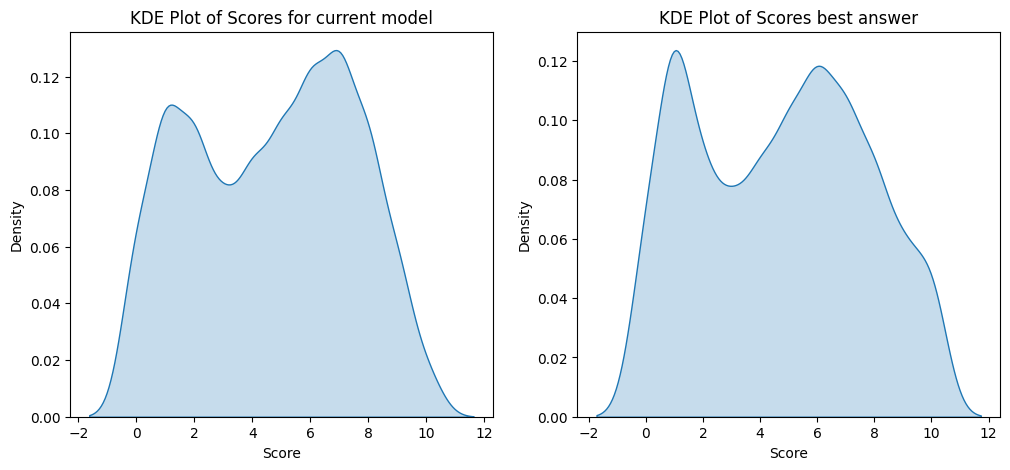

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
sns.kdeplot(data=ans, x="score", fill=True, ax=axes[0])
axes[0].set_title("KDE Plot of Scores for current model")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Density")

# Second subplot
sns.kdeplot(data=best_ans, x="score", fill=True, ax=axes[1])
axes[1].set_title("KDE Plot of Scores best answer")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Density")
